## <a id='toc1_1_'></a>[Análisis del dataset GoodBooks10k-Extended](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Análisis del dataset GoodBooks10k-Extended](#toc1_1_)    
    - [Introducción](#toc1_1_1_)    
    - [Análisis del dataset de libros](#toc1_1_2_)    
    - [Análisis del dataset de ratings de usuarios](#toc1_1_3_)    
    - [Otros datasets](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introducción](#toc0_)

Este dataset procede del repositorio <a href="https://github.com/malcolmosh/goodbooks-10k-extended">GoodBooks 10k Extended</a>. A lo largo del *notebook* iremos analizando aspectos de interés del dataset. También lo modificaremos para que se ajuste al futuro sistema recomendador de libros, consistente en comprensión de lenguaje natural de las sinopsis, en combinación con el contenido de otros atributos.

### <a id='toc1_1_2_'></a>[Análisis del dataset de libros](#toc0_)

In [1]:
import pandas as pd
from ast import literal_eval

path = 'datasets/goodbooks_ext/'
books = pd.read_csv(path + 'books_enriched.csv', index_col=[0], converters={"genres": literal_eval})

Comprobamos la información del dataset en cuanto a las columnas de las que consiste, así como los tipos de los datos presentes en ellas y cuántos de ellos son no nulos.

In [2]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      10000 non-null  int64  
 1   authors                    10000 non-null  object 
 2   average_rating             10000 non-null  float64
 3   best_book_id               10000 non-null  int64  
 4   book_id                    10000 non-null  int64  
 5   books_count                10000 non-null  int64  
 6   description                9943 non-null   object 
 7   genres                     10000 non-null  object 
 8   goodreads_book_id          10000 non-null  int64  
 9   image_url                  10000 non-null  object 
 10  isbn                       9300 non-null   object 
 11  isbn13                     9415 non-null   float64
 12  language_code              10000 non-null  object 
 13  original_publication_year  9979 non-null   float64
 

Para nuestro proyecto, los atributos de mayor interés serán:
- `description`: ofrece una descripción del libro (sinopsis, u otra información del producto)
- `title`/`original_title`: título del libro (o su versión original)
- `authors`/`authors_2`: autores y colaboradores (ilustradores, traductores, etc.) del libro
- `genres`: géneros en los cuales cae el libro

Esto se debe a que enfocaremos el sistema a recomendaciones de tipo *Content-Based*, apoyándonos en comprensión de lenguaje natural para extraer contenido útil de las descripciones de los libros del dataset.

Otros atributos menores, pero que también podrían ser útiles para recomendaciones en base al contenido o el estilo son los siguientes:
- `pages`: número de páginas del libro
- `original_publication_year`: año original de publicación del libro

Adicionalmente, los atributos que tienen que ver con el número de reviews (principalmente `work_ratings_count`) nos serán de utilidad. Esto es, para comprobar si un libro ha sido lo suficientemente valorado como para presentar una nota que se ajuste a la opinión real de cualquier persona que escoja leer esa obra. El atributo `work_text_reviews_count` puede servir para entender si un libro concita un interés de importancia, pues los usuarios que lo leyeron también dieron una valoración escrita, más extensa (requiere un esfuerzo mayor).

Por supuesto, `average_rating` jugará también un papel fundamental si decidimos hacer un filtrado a partir de la nota que tengan los libros candidatos a ser recomendados. Esto supondría una hibridación del sistema recomendador entre *Content-Based* y *Collaborative Filtering*.

Por otra parte, hay algunos atributos que no nos interesarán. Estos son `index`, `books_count`, `best_book_id`, `goodreads_book_id` y `ratings_count`. 

Algunos de estos se refieren a los identificadores que se les asignó en una de las colecciones de *GoodReads* sobre los mejores libros de la historia (en opinión de usuarios).

En el caso de `ratings_count`, hemos decidido eliminar esta columna, ya que corresponde a la edición del libro de la que se hace referencia en el dataset, pero no a la obra como tal. Para ese dato ya contamos con el atributo `work_ratings_count`, mencionado con anterioridad.

In [3]:
del books['index'], books['best_book_id'], books['goodreads_book_id']
del books['books_count'], books['ratings_count']
books.head()

,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,['Suzanne Collins'],4.34,1,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"[young-adult, fiction, fantasy, science-fictio...",https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,"['J.K. Rowling', 'Mary GrandPré']",4.44,2,Harry Potter's life is miserable. His parents ...,"[fantasy, fiction, young-adult, classics]",https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,...,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,['Stephenie Meyer'],3.57,3,About three things I was absolutely positive.\...,"[young-adult, fantasy, romance, fiction, paran...",https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,...,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,['Harper Lee'],4.25,4,The unforgettable novel of a childhood in a sl...,"[classics, fiction, historical-fiction, young-...",https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,...,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,['F. Scott Fitzgerald'],3.89,5,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"[classics, fiction, historical-fiction, romance]",https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,...,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']


Finalmente, hay otros atributos que, si bien no usaremos frecuentemente, sí nos puede interesar dejarlos como están en el dataset. Hablamos de aquellos sobre metadatos de los libros, como son el ISBN o las imágenes de las portadas.

Podemos obtener información útil de los atributos cuantitativos del dataset.

In [4]:
books.describe()

,average_rating,book_id,isbn13,original_publication_year,pages,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,work_id,work_ratings_count,work_text_reviews_count
count,10000.000000,10000.00000,9.415000e+03,9979.000000,9927.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,4.002191,5000.50000,9.755044e+12,1981.987674,359.419764,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04,8.646183e+06,5.968732e+04,2919.955300
std,0.254427,2886.89568,4.428619e+11,152.576665,216.949919,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04,1.175106e+07,1.678038e+05,6124.378132
min,2.470000,1.00000,1.951703e+08,-1750.000000,0.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02,8.700000e+01,5.510000e+03,3.000000
25%,3.850000,2500.75000,9.780316e+12,1990.000000,250.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03,1.008841e+06,1.543875e+04,694.000000
50%,4.020000,5000.50000,9.780452e+12,2004.000000,336.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03,2.719524e+06,2.383250e+04,1402.000000
75%,4.180000,7500.25000,9.780831e+12,2011.000000,424.000000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04,1.451775e+07,4.591500e+04,2744.250000
max,4.820000,10000.00000,9.790008e+12,2017.000000,5216.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06,5.639960e+07,4.942365e+06,155254.000000


Comprobamos que el libro que menor número de reviews tiene aun así cuenta con un total de valoraciones que podemos considerar significativo (dispone de 5510 valoraciones). Podemos comprobar con más detalle qué porcentaje de libros cuenta con más de 10000 valoraciones.

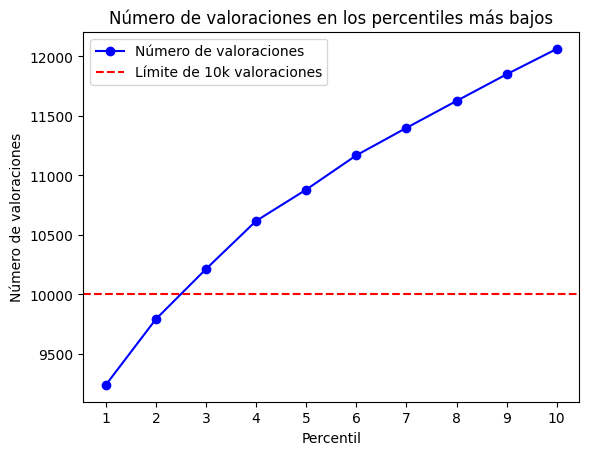

In [5]:
import numpy as np
import matplotlib.pyplot as plt

m = 1
M = 10
paso = 1
num_ratings_percentile = [(i, np.percentile(books['work_ratings_count'], i)) for i in range(m, M + 1, paso)]

# Gráfica para comprobar qué porcentaje de libros tienen menos de 10k valoraciones
plt.plot([x[0] for x in num_ratings_percentile], [x[1] for x in num_ratings_percentile], 'bo-')
plt.axhline(y=10000, color='r', linestyle='--')
plt.xticks(np.arange(m, M + 1, paso))
plt.xlabel('Percentil')
plt.ylabel('Número de valoraciones')
plt.title('Número de valoraciones en los percentiles más bajos')
plt.legend(['Número de valoraciones', 'Límite de 10k valoraciones'])
plt.show()

Vemos que aproximadamente el 97% de libros cuenta con más de 10000 reseñas. Tenemos un dataset que, en líneas generales, es robusto en cuanto a número de valoraciones por libro, pues la gran mayoría tiene más de 9000 valoraciones según el gráfico. En este sentido, es probable que no tengamos que recortar el dataset de los libros, ya que todos disponen de un número de reviews suficiente como para ser tenidos en cuenta por el sistema recomendador.

Ahora, nos centraremos en aspectos cualitativos más específicos del dataset.

Primero vamos a comprobar cuántos libros no disponen de descripción y cuáles son, para, en función de su grado de conocimiento, descartarlos o, por el contrario, añadir con paciencia alguna descripción si son de interés.

In [6]:
no_description = books[books['description'].isna()].sort_values(by='work_ratings_count')
no_description

,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
7866,['عمرو سلامة'],3.66,9555,NaN,"[nonfiction, philosophy]",https://images.gr-assets.com/books/1309784315m...,NaN,9.789776e+12,ara,2011.0,...,825,2179,2610,2156,https://images.gr-assets.com/books/1309784315s...,شاب كشك في رحلة البحث عن الجادون,16903753,8128,846,['عمرو سلامة']
7483,['Gayle Forman'],4.24,8971,NaN,"[young-adult, romance, fiction, contemporary, ...",https://images.gr-assets.com/books/1441837844m...,147515025,9.780148e+12,eng,2014.0,...,312,1245,2462,4273,https://images.gr-assets.com/books/1441837844s...,"If I Stay Collection (If I Stay, #1-2)",41164642,8428,509,['Gayle Forman']
9947,['[Justine Korman Fontes]'],4.48,9818,NaN,"[fiction, fantasy, comics, books, romance, cla...",https://s.gr-assets.com/assets/nophoto/book/11...,717283534,9.780717e+12,eng,1994.0,...,212,1121,1627,6287,https://s.gr-assets.com/assets/nophoto/book/50...,The Lion King (Disney's Wonderful World of Rea...,40728295,9340,34,['[Justine Korman Fontes]']
9297,['[Amazon]'],3.64,7803,NaN,"[history, nonfiction]",https://s.gr-assets.com/assets/nophoto/book/11...,NaN,NaN,eng,2009.0,...,944,1810,2292,3721,https://s.gr-assets.com/assets/nophoto/book/50...,Kindle User's Guide,14286509,9964,29,['[Amazon]']
7098,"['Ludwig Wittgenstein', 'G.E.M. Anscombe']",4.23,8390,NaN,"[philosophy, nonfiction, classics, psychology]",https://s.gr-assets.com/assets/nophoto/book/11...,631231277,9.780631e+12,eng,1953.0,...,389,1389,2869,5198,https://s.gr-assets.com/assets/nophoto/book/50...,Philosophical Investigations,2078450,10085,224,"['Ludwig Wittgenstein', 'G.E.M. Anscombe']"
8099,['Chuck Palahniuk'],3.93,9900,NaN,"[fiction, horror, contemporary, thriller]",https://images.gr-assets.com/books/1273235556m...,NaN,NaN,eng,2004.0,...,701,2047,3302,3898,https://images.gr-assets.com/books/1273235556s...,Guts,6584446,10332,492,['Chuck Palahniuk']
9751,['[Gerald N. Lund]'],4.30,9241,NaN,"[historical-fiction, fiction, religion, histor...",https://s.gr-assets.com/assets/nophoto/book/11...,1590384989,9.781590e+12,eng,1992.0,...,191,1484,3732,5164,https://s.gr-assets.com/assets/nophoto/book/50...,"Truth Will Prevail (The Work and the Glory, #3)",371565,10604,198,['[Gerald N. Lund]']
9702,"['[Eugene Bradley Coco', 'Ron Dias]']",4.33,9120,NaN,"[fiction, fantasy, classics]",https://s.gr-assets.com/assets/nophoto/book/11...,307021858,9.780307e+12,eng,1992.0,...,358,1704,2158,6277,https://s.gr-assets.com/assets/nophoto/book/50...,Pinocchio,521194,10627,25,"['[Eugene Bradley Coco', 'Ron Dias]']"
7159,"['Aristotle', 'Joe Sachs']",4.00,8472,NaN,"[philosophy, classics, nonfiction, history, sc...",https://images.gr-assets.com/books/1355049704m...,1888009039,9.781888e+12,eng,-330.0,...,607,2377,3299,4181,https://images.gr-assets.com/books/1355049704s...,Metaphysics,2479557,10645,129,"['Aristotle', 'Joe Sachs']"
9625,"['[Warren Ellis', 'Darick Robertson', 'Rodney ...",4.40,8880,NaN,"[comics, graphic-novels, science-fiction, fict...",https://images.gr-assets.com/books/1374683445m...,1563897229,9.781564e+12,eng,2001.0,...,242,1092,3134,6424,https://images.gr-assets.com/books/1374683445s...,"Transmetropolitan, Vol. 5: Lonely City (Transm...",23446,11045,156,"['[Warren Ellis', 'Darick Robertson', 'Rodney ..."


Después de comprobar por encima este conjunto de libros, llevamos a cabo algunas transformaciones del dataset.

Eliminamos el primer libro, poco conocido y sin descripción disponible en la red. También la *Guía de Usuario de Kindle*, la cual no es de mayor interés.

In [7]:
books = books.drop([7866, 9297]) # Elimina dichos libros

El resto son libros con un importante número de valoraciones como para ser descartados, entre los que se incluyen históricas obras filosóficas y clásicos de la literatura. Podemos añadir manualmente (no son tantas sin completar) o mediante alguna utilidad/API las descripciones que faltan.

In [8]:
# Potencial código para ir añadiendo las descripciones de dichos libros

También nos interesa conocer qué entradas del dataset hacen referencia a una colección de libros de la misma saga, pues sus títulos ya son considerados como libros por separado en el dataset. 

A la hora de recomendar, se tendrá que decidir si se opta por incluir también las colecciones como obras aparte (englobando los libros de una misma saga) o son descartados por su redundancia, además del hecho de que sus sinopsis, en algunos casos, conciernen al producto como boxset más que como serie literaria.

In [9]:
books_collection = books[books['title'].str.contains('Collection')]
books_collection

,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
691,"['Laura Ingalls Wilder', 'Garth Williams']",4.33,740,This nine-book paperback box set of the classi...,"[classics, historical-fiction, fiction, young-...",https://s.gr-assets.com/assets/nophoto/book/11...,60529962,9.780061e+12,eng,1953.0,...,3046,15651,36875,71004,https://s.gr-assets.com/assets/nophoto/book/50...,"The Little House Collection (Little House, #1-9)",2852640,128880,2016,"['Laura Ingalls Wilder', 'Garth Williams']"
941,['Chelsea Handler'],3.79,1007,You've either done it or know someone who has:...,"[nonfiction, memoir, biography, chick-lit]",https://images.gr-assets.com/books/1388631721m...,1582346186,9.781582e+12,eng,2004.0,...,7349,22943,29859,26447,https://images.gr-assets.com/books/1388631721s...,My Horizontal Life: A Collection of One-Night ...,979256,89257,6051,['Chelsea Handler']
976,['Veronica Roth'],4.10,1045,Two years before Beatrice Prior made her choic...,"[young-adult, fiction, science-fiction, fantas...",https://images.gr-assets.com/books/1393687572m...,62285688,9.780062e+12,eng,2014.0,...,4985,22456,40265,47338,https://images.gr-assets.com/books/1393687572s...,"Four: A Divergent Story Collection (Divergent,...",25457412,116243,9213,['Veronica Roth']
1520,['Stephenie Meyer'],4.31,1619,"This stunning set, complete with five editions...","[fantasy, young-adult, romance, paranormal, fi...",https://s.gr-assets.com/assets/nophoto/book/11...,031613290X,9.780316e+12,eng,2005.0,...,2306,6572,10599,36050,https://s.gr-assets.com/assets/nophoto/book/50...,The Twilight Saga Complete Collection (Twilig...,14194990,57789,335,['Stephenie Meyer']
1899,['Stephenie Meyer'],3.78,2021,Deeply romantic and extraordinarily suspensefu...,"[young-adult, fantasy, romance, paranormal, fi...",https://s.gr-assets.com/assets/nophoto/book/11...,316003727,9.780316e+12,eng,2007.0,...,3613,6924,8607,18679,https://s.gr-assets.com/assets/nophoto/book/50...,"The Twilight Collection (Twilight, #1-3)",3187048,42383,1127,['Stephenie Meyer']
1969,"['J.K. Rowling', 'Mary GrandPré']",4.66,2101,"The exciting tales of Harry Potter, the young ...","[fantasy, young-adult, fiction, classics]",https://s.gr-assets.com/assets/nophoto/book/11...,439249546,9.780439e+12,eng,1999.0,...,424,2346,8186,33579,https://s.gr-assets.com/assets/nophoto/book/50...,"The Harry Potter Collection 1-4 (Harry Potter,...",5994366,44842,265,"['J.K. Rowling', 'Mary GrandPré']"
2876,['Richelle Mead'],4.61,3095,Tear into the utterly addictive Vampire Academ...,"[young-adult, fantasy, paranormal, romance, fi...",https://s.gr-assets.com/assets/nophoto/book/11...,1595142711,9.781595e+12,fr,2009.0,...,426,2082,5168,22548,https://s.gr-assets.com/assets/nophoto/book/50...,"Vampire Academy Collection (Vampire Academy, #...",10954714,30509,182,['Richelle Mead']
3457,['J.K. Rowling'],4.73,3753,"Six years of magic, adventure, and mystery mak...","[fantasy, fiction, young-adult, classics]",https://images.gr-assets.com/books/1328867351m...,439827604,9.780440e+12,eng,2005.0,...,186,946,3891,21048,https://images.gr-assets.com/books/1328867351s...,"Harry Potter Collection (Harry Potter, #1-6)",21457570,26274,882,['J.K. Rowling']
4068,['Bill Watterson'],4.75,4483,When cartoonist Bill Watterson announced that ...,"[comics, graphic-novels, fiction]",https://images.gr-assets.com/books/1437420710m...,836221362,9.780836e+12,eng,1996.0,...,57,850,3737,18749,https://images.gr-assets.com/books/1437420710s...,It's a Magical World: A Calvin and Hobbes Coll...,25601,23429,264,['Bill Watterson']
4670,['Bill Watterson'],4.68,5207,"Zounds! Spaceman Spiff, Stupendous Man, the fe...","[comics, fiction, graphic-novels]",https://images.gr-assets.com/books/1418211162m...,836217357,9.780836e+12,eng,1993.0,...,149,942,3636,15533,https://images.gr-assets.com/books/14182111

Por otro lado, también contabilizamos aquellos libros en cuya descripción encontramos otro tipo de datos ajenos a una sinopsis, como es la palabra ISBN. Esto es un dato que nos puede interesar de cara a la extracción de información a partir de NLP.

In [10]:
books_desc_isbn = books[(books['description'].notna()) & (books['description'].str.contains('ISBN'))]
print(len(books_desc_isbn))
books_desc_isbn.head()

162


,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
4,['F. Scott Fitzgerald'],3.89,5,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"[classics, fiction, historical-fiction, romance]",https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,...,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']
9,['Jane Austen'],4.24,10,Alternate cover edition of ISBN 9780679783268S...,"[classics, fiction, romance, historical-fiction]",https://images.gr-assets.com/books/1320399351m...,679783261,9.780680e+12,eng,1813.0,...,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351s...,Pride and Prejudice,3060926,2191465,49152,['Jane Austen']
13,"['Stieg Larsson', 'Reg Keeland']",4.11,16,"Harriet Vanger, a scion of one of Sweden’s wea...","[fiction, mystery, suspense, contemporary, thr...",https://images.gr-assets.com/books/1327868566m...,307269752,9.780307e+12,eng,2005.0,...,86051,285413,667485,836050,https://images.gr-assets.com/books/1327868566s...,"The Girl with the Dragon Tattoo (Millennium, #1)",1708725,1929834,62543,"['Stieg Larsson', 'Reg Keeland']"
22,['Dan Brown'],3.79,26,ISBN 9780307277671 moved to this edition.While...,"[fiction, mystery, thriller, suspense, histori...",https://images.gr-assets.com/books/1303252999m...,307277674,9.780307e+12,eng,2003.0,...,126493,340790,539277,479387,https://images.gr-assets.com/books/1303252999s...,"The Da Vinci Code (Robert Langdon, #2)",2982101,1557292,41560,['Dan Brown']
36,['Rick Riordan'],4.23,41,Alternate cover for this ISBN can be found her...,"[fantasy, young-adult, fiction]",https://images.gr-assets.com/books/1400602609m...,786838655,9.780787e+12,eng,2005.0,...,48294,219638,435514,689365,https://images.gr-assets.com/books/1400602609s...,The Lightning Thief (Percy Jackson and the Oly...,3346751,1411114,46006,['Rick Riordan']


Otro detalle que podemos comprobar es el atributo `language_code` de los libros del dataset. Este se refiere al código del idioma en que está el libro, tratado como producto, y que puede afectar a la hora de comprender las sinopsis a partir de un tratamiento por NLP.

In [11]:
books.groupby('language_code').count()

,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,original_publication_year,original_title,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
language_code,,,,,,,,,,,,,,,,,,,,,
af,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ara,63,63,63,63,63,63,11,33,62,57,...,63,63,63,63,63,63,63,63,63,63
cs,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
da,7,7,7,7,7,7,6,6,7,7,...,7,7,7,7,7,7,7,7,7,7
dan,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
de,33,33,33,31,33,33,29,29,33,27,...,33,33,33,33,33,33,33,33,33,33
eng,9679,9679,9679,9628,9679,9679,9059,9144,9659,9118,...,9679,9679,9679,9679,9679,9679,9679,9679,9679,9679
es,21,21,21,20,21,21,21,21,21,19,...,21,21,21,21,21,21,21,21,21,21
et,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Como vemos, hay una clara predominancia de libros en inglés. Sin embargo, también destaca el total de libros en árabe, español, alemán o francés. Comprobemos si, en efecto, estos libros disponen de una descripción en dichos idiomas.

In [12]:
def books_lang(language_code):
    """
    Retorna un dataframe con los libros del lenguaje indicado
    """
    return books[books['language_code'] == language_code]

books_arabic = books_lang('ara')
books_arabic.head()

,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
1286,['أحمد مراد'],3.80,1372,بعد خمس سنوات من العُزلة الاختيارية يستأنف د. ...,"[fiction, horror, mystery, fantasy, psychology...",https://images.gr-assets.com/books/1485105416m...,NaN,9.789771e+12,ara,2012.0,...,4687,11444,16996,18433,https://images.gr-assets.com/books/1485105416s...,الفيل الأزرق,21801712,54340,5771,['أحمد مراد']
1386,"['أحلام مستغانمي', 'Ahlam Mosteghanemi']",3.72,1475,ما من قصة حب إلا و تبدأ بحركة موسيقية ، قائد ا...,"[romance, fiction]",https://images.gr-assets.com/books/1351004560m...,NaN,9.789953e+12,ara,2012.0,...,5535,11642,13878,17877,https://images.gr-assets.com/books/1351004560s...,الأسود يليق بك,21881449,52255,5459,"['أحلام مستغانمي', 'Ahlam Mosteghanemi']"
1547,['أحمد مراد'],4.09,1647,"""للمرة الثانية بعد ""فيرتيجو"" يتّخذ أحمد مراد م...","[fiction, crime, thriller, contemporary, fantasy]",https://s.gr-assets.com/assets/nophoto/book/11...,NaN,NaN,ara,2010.0,...,2050,7402,16743,18418,https://s.gr-assets.com/assets/nophoto/book/50...,تراب الماس,10406860,45608,4027,['أحمد مراد']
1678,['محمد صادق'],3.82,1787,تأخذنا رواية (هيبتا) إلي ذلك العالم الذي أهلكه...,"[romance, fiction, philosophy, contemporary]",https://images.gr-assets.com/books/1403045796m...,NaN,NaN,ara,2014.0,...,4135,8052,11237,16988,https://images.gr-assets.com/books/1403045796s...,هيبتا,28155746,43298,5680,['محمد صادق']
1817,['أثير عبدالله النشمي'],3.67,1933,"""أجلس اليوم إلى جوارك، أندب أحلامي الحمقى.. غا...","[romance, fiction]",https://s.gr-assets.com/assets/nophoto/book/11...,NaN,9.789954e+12,ara,2010.0,...,4620,8914,10505,14755,https://s.gr-assets.com/assets/nophoto/book/50...,أحببتك أكثر مما ينبغي,7379975,42357,4898,['أثير عبدالله النشمي']


In [13]:
books_spanish = pd.concat([books_lang('spa'), books_lang('es')])
print(len(books_spanish))
books_spanish.head(10)

41


,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
513,['Stephen King'],3.65,556,"Outside a peaceful town in central Maine, a mo...","[horror, fiction, thriller, suspense, fantasy]",https://images.gr-assets.com/books/1394208144m...,307348245,9.780307e+12,spa,1981.0,...,16130,54393,52708,39717,https://images.gr-assets.com/books/1394208144s...,Cujo,996156,167044,2832,['Stephen King']
860,"['Stephen King', 'Bettina Blanch Tyroller']",3.79,915,"Ralph Roberts, a sus setenta años y tras la mu...","[horror, fiction, fantasy, thriller, mystery, ...",https://images.gr-assets.com/books/1354355494m...,8497597729,9.788498e+12,spa,1994.0,...,9066,28408,35608,33224,https://images.gr-assets.com/books/1354355494s...,Insomnia,1590722,109444,2296,"['Stephen King', 'Bettina Blanch Tyroller']"
1690,"['Philip K. Dick', 'David Alabort', 'Manuel Es...",4.10,1800,Glen Runciter está muerto. ¿O lo están todos l...,"[science-fiction, fiction, classics, mystery, ...",https://s.gr-assets.com/assets/nophoto/book/11...,8498000831,9.788498e+12,spa,1969.0,...,2176,10594,22241,22504,https://s.gr-assets.com/assets/nophoto/book/50...,Ubik,62929,58063,2957,"['Philip K. Dick', 'David Alabort', 'Manuel Es..."
1707,['Clive Cussler'],3.95,1817,"1996, Egypt. Searching for a treasure on the N...","[fiction, thriller, mystery, suspense, histori...",https://s.gr-assets.com/assets/nophoto/book/11...,030720961X,9.780307e+12,spa,1992.0,...,2145,11351,18747,15741,https://s.gr-assets.com/assets/nophoto/book/50...,"Sahara (Dirk Pitt, #11)",2467487,48850,745,['Clive Cussler']
3223,['Anne Rice'],3.73,3477,"Anne Rice, creator of the Vampire Lestat, the ...","[horror, fantasy, fiction, paranormal, histori...",https://s.gr-assets.com/assets/nophoto/book/11...,8466302948,9.788466e+12,spa,1998.0,...,3436,11000,11390,10437,https://s.gr-assets.com/assets/nophoto/book/50...,"Pandora (New Tales of the Vampires, #1)",2926330,37086,672,['Anne Rice']
3432,['Ernesto Sabato'],4.04,3719,"Breve e intensa novela publicada en 1948, este...","[fiction, classics, thriller]",https://s.gr-assets.com/assets/nophoto/book/11...,9871144261,9.789871e+12,spa,1948.0,...,1433,5352,10494,10592,https://s.gr-assets.com/assets/nophoto/book/50...,El túnel,5793,28256,1618,['Ernesto Sabato']
3456,['Agatha Christie'],4.07,3752,The very first collection of superb short stor...,"[mystery, fiction, crime, classics]",https://images.gr-assets.com/books/1359475912m...,NaN,NaN,spa,1924.0,...,1003,6529,10450,11210,https://images.gr-assets.com/books/1359475912s...,"Poirot Investiga (Hércules Poirot, #3)",1952109,29408,779,['Agatha Christie']
3797,['Ildefonso Falcones'],4.05,4152,Siglo XIV. La ciudad de Barcelona se encuentra...,"[historical-fiction, fiction, romance]",https://images.gr-assets.com/books/1366301973m...,307376656,9.780307e+12,spa,2006.0,...,1350,4363,9007,10025,https://images.gr-assets.com/books/1366301973s...,La catedral del mar,2731326,25313,1387,['Ildefonso Falcones']
4088,['Roberto Bolaño'],4.20,4509,"A cuatro profesores de literatura, Pelletier, ...","[fiction, mystery, contemporary, crime, classics]",https://images.gr-assets.com/books/1412644327m...,843396867X,9.788434e+12,spa,2004.0,...,1147,2739,6398,11412,https://images.gr-assets.com/books/1412644327s...,2666,3294830,22318,2930,['Roberto Bolaño']
4168,['Isabel Allende'],4.07,4606,"Paula es el libro más conmovedor, más personal...","[nonfiction, memoir, biography]",https://images.gr-assets.com/books/1316284499m...,849759388X,9.788498e+12,spa,1994.0,...,1120,4491,8073,9501,https://images.gr-assets.com/books/1316284499s...,Paula,419162,23529,1447,['Isabel Allende']


In [14]:
books_french = pd.concat([books_lang('fre'), books_lang('fr')])
print(len(books_french))
books_french.head(10)

43


,authors,average_rating,book_id,description,genres,image_url,isbn,isbn13,language_code,original_publication_year,...,ratings_2,ratings_3,ratings_4,ratings_5,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
534,"['Stephen King', 'Marie Milpois']",3.72,578,Master storyteller Stephen King presents the c...,"[horror, fiction, thriller, fantasy, paranorma...",https://images.gr-assets.com/books/1327270815m...,2253147699,9.782253e+12,fre,1983.0,...,14024,48479,49499,42506,https://images.gr-assets.com/books/1327270815s...,Christine,1150571,157664,2092,"['Stephen King', 'Marie Milpois']"
738,"['Irvine Welsh', 'Eric Lindor Fall']",4.07,788,The bestselling novel by Irvine Welsh that pro...,"[fiction, contemporary, classics, thriller, my...",https://images.gr-assets.com/books/1375258001m...,2020336464,9.782020e+12,fre,1993.0,...,4329,19778,42833,41980,https://images.gr-assets.com/books/1375258001s...,Trainspotting,1087421,110677,2029,"['Irvine Welsh', 'Eric Lindor Fall']"
767,"['Stephen King', 'William Olivier Desmond']",3.59,818,"Au coeur de la forêt de Derry, quatre amis d'e...","[horror, fiction, science-fiction, thriller, f...",https://s.gr-assets.com/assets/nophoto/book/11...,2226131906,9.782226e+12,fre,2001.0,...,14010,36926,36389,30040,https://s.gr-assets.com/assets/nophoto/book/50...,Dreamcatcher,643924,122599,1856,"['Stephen King', 'William Olivier Desmond']"
1004,"['Stephen King', 'Dominique Dill']",3.81,1075,"Suspected of killing Vera Donovan, her wealthy...","[horror, fiction, thriller, mystery, suspense,...",https://images.gr-assets.com/books/1394213480m...,2266047426,9.782266e+12,fre,1992.0,...,7586,27461,33524,28765,https://images.gr-assets.com/books/1394213480s...,Dolores Claiborne,6560478,98959,1718,"['Stephen King', 'Dominique Dill']"
2233,['Marjane Satrapi'],4.27,2386,"Première bande dessinée issue de l'Iran, Perse...","[graphic-novels, comics, nonfiction, memoir, h...",https://images.gr-assets.com/books/1375777630m...,2844140580,9.782844e+12,fre,2000.0,...,1409,5430,14422,24672,https://images.gr-assets.com/books/1375777630s...,"Persepolis, Volume 1",25686510,47133,301,['Marjane Satrapi']
2521,['Hunter S. Thompson'],4.00,2703,"Au début des années soixante, Thompson, alors ...","[nonfiction, history, memoir, biography, crime...",https://s.gr-assets.com/assets/nophoto/book/11...,222109073X,9.782221e+12,fre,1966.0,...,1203,7385,14227,10312,https://s.gr-assets.com/assets/nophoto/book/50...,Hell's Angels: A Strange and Terrible Saga,1999152,33303,1173,['Hunter S. Thompson']
2652,['Joël Dicker'],3.94,2847,"À New York, au printemps 2008, alors que l’Amé...","[fiction, mystery, thriller, crime, contempora...",https://images.gr-assets.com/books/1347987605m...,2877068161,9.782877e+12,fre,2011.0,...,2707,7257,14067,14957,https://images.gr-assets.com/books/1347987605s...,La Vérité sur l'affaire Harry Quebert,21805083,40614,5284,['Joël Dicker']
4411,"['René Goscinny', 'Jean-Jacques Sempé']",4.13,4902,"La maîtresse est inquiète, le photographe s'ép...","[fiction, classics, young-adult]",https://s.gr-assets.com/assets/nophoto/book/11...,2070364232,9.782070e+12,fre,1959.0,...,1052,5006,9303,11659,https://s.gr-assets.com/assets/nophoto/book/50...,"Le Petit Nicolas (Le petit Nicolas, #1)",123908,27363,514,"['René Goscinny', 'Jean-Jacques Sempé']"
4564,"['Sui Ishida', '石田 スイ']",4.43,5074,"À Tokyo, sévissent des goules, monstres cannib...","[manga, horror, graphic-novels, fantasy, comic...",https://images.gr-assets.com/books/1498748457m...,2723495612,9.782723e+12,fre,2012.0,...,1077,4554,10673,29027,https://images.gr-assets.com/books/1498748457s...,"Tokyo Ghoul, tome 1 (Tokyo Ghoul, #1)",26492586,46108,940,"['Sui Ishida', '石田 スイ']"
5295,"['Arthur C. Clarke', 'Gentry Lee']",3.66,5982,70 years after the events of Rendezvous with R...,"[science-fiction, fiction, fantasy]",https://images.gr-assets.com/books/1375814981m...,2290032042,9.782290e+12,fre,1989.0,...,1612,5312,6335,4015,https://images.gr-assets.com/b

Como vemos, sí hay buena parte de los libros con esos códigos de idioma que presentan una descripción en dicho idioma. Se tendrá que tener en cuenta en el futuro análisis por comprensión de lenguaje natural.

### <a id='toc1_1_3_'></a>[Análisis del dataset de ratings de usuarios](#toc0_)

In [15]:
user_ratings = pd.read_csv(path + 'ratings.csv')

Comprobamos los detalles del dataset, esta vez para las valoraciones de usuarios.

In [16]:
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


En este dataset encontramos tres columnas:

- `user_id`: el identificador del usuario de *GoodReads*
- `book_id`: el identificador del libro en el dataset de los libros
- `rating`: valoración del 1 al 5 que el usuario dio a dicho libro

Si bien el sistema recomendador será *Content-Based*, este dataset puede ser útil a la hora de comprender los gustos de los usuarios basándonos en su historial de lecturas y las valoraciones dadas. En ese caso, nos interesarán aquellos usuarios con un número significativo de ratings.

In [17]:
user_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


Incluimos un análisis generalizado del dataset.

In [18]:
user_ratings.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


Como comprobamos, la nota media de los libros es de 3.92, un valor que nos puede dar algunas indicaciones sobre el dataset de libros. Al ser una nota relativamente generosa, se puede llegar a la conclusión de que los libros del dataset son, en general, populares y bien valorados entre la población. A priori, esto no es algo negativo, ya que al ser un dataset más o menos extenso, hay la suficiente variedad de libros como para dar una recomendación que se ajuste a las preferencias del usuario. 

No obstante, puede ocurrir que obras menos conocidas se vean perjudicadas en el sentido de que no sean recomendadas lo suficiente como para llegar a un público que ya conoce de antemano los libros más populares y busca algo más selecto (diamantes en bruto). Esto enlaza con otra de las conclusiones que podemos extraer de este dataset. 

Podría ocurrir que la muestra de usuarios esté algo sesgada a la hora de valorar los libros que lee, dando con muchísima más frecuencia notas entre 4 y 5 a libros que, en teoría, se corresponderían más con un 3, por ejemplo. Por supuesto, cada usuario da su valoración libremente, pero cuando se trata de un fenómeno acumulado, es un dato a tener en cuenta. Para esto último, comprobemos mediante un histograma cómo se distibuyen las valoraciones entre los usuarios.

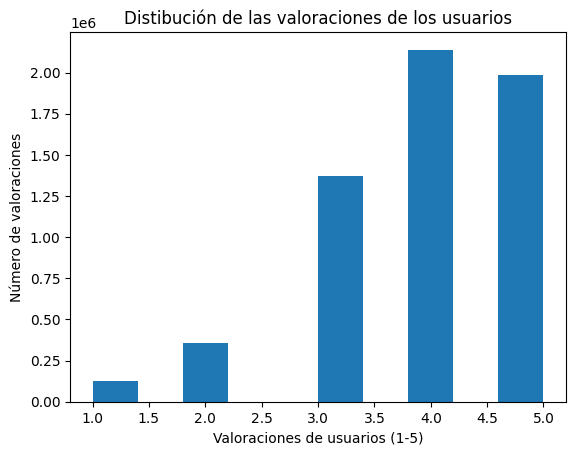

In [19]:
# Histograma de las valoraciones de los usuarios
plt.hist(user_ratings['rating'])
plt.xlabel('Valoraciones de usuarios (1-5)')
plt.ylabel('Número de valoraciones')
plt.title('Distibución de las valoraciones de los usuarios')
plt.show()

El histograma nos confirma que la gran mayoría de libros reciben valoraciones de 4 o 5, seguido de una importante cantidad de valoraciones con un 3. Hay una asimetría a la izquierda que, si bien puede ser lógica por los libros incluidos en el dataset, no debemos perder de vista.

Ahora comprobemos el número de valoraciones por usuario para hacernos una idea de cuántos o cuáles usuarios deben ser tenidos en cuenta en caso de incorporar un mecanismo de *Collaborative Filtering*.

In [20]:
# Agrupar por usuario y contar el número de valoraciones que ha hecho cada uno
users_n_ratings = user_ratings.groupby('user_id').count()
users_n_ratings.describe()

,book_id,rating
count,53424.000000,53424.000000
mean,111.868804,111.868804
std,26.071224,26.071224
min,19.000000,19.000000
25%,96.000000,96.000000
50%,111.000000,111.000000
75%,128.000000,128.000000
max,200.000000,200.000000


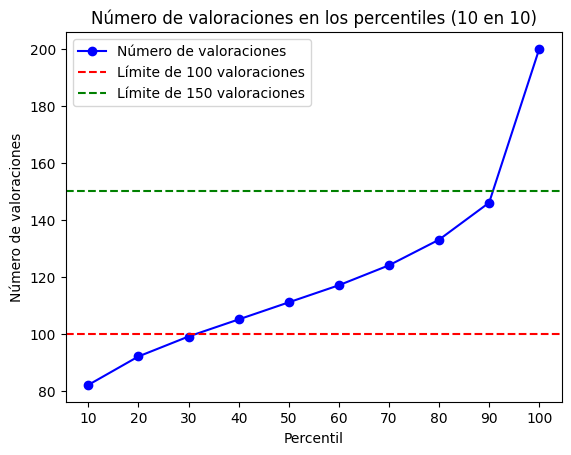

In [21]:
m = 10
M = 100
paso = 10
num_ratings_percentile = [(i, np.percentile(users_n_ratings['rating'], i)) for i in range(m, M + 1, paso)]

# Gráfica para comprobar qué porcentaje de libros tienen menos de 10k valoraciones
plt.plot([x[0] for x in num_ratings_percentile], [x[1] for x in num_ratings_percentile], 'bo-')
plt.axhline(y=100, color='r', linestyle='--')
plt.axhline(y=150, color='g', linestyle='--')
plt.xticks(np.arange(m, M + 1, paso))
plt.xlabel('Percentil')
plt.ylabel('Número de valoraciones')
plt.title('Número de valoraciones en los percentiles (10 en 10)')
plt.legend(['Número de valoraciones', 'Límite de 100 valoraciones', 'Límite de 150 valoraciones'])
plt.show()

En este caso, aproximadamente un 70% de los usuarios recogidos en el dataset ha hecho más de 100 valoraciones. El límite inferior de 100 valoraciones me ha parecido una cantidad razonable, incluso algo exigente, para saber qué usuarios pueden interesar en base a sus preferencias. Cuando un usuario ha valorado 100 libros o más, nos podemos hacer una idea mucho mejor de su perfil como lector. 

También incluimos un límite superior de 150 valoraciones. Esto último es más bien por curiosidad (una cantidad casi arbitraria), aunque tiene que ver con que existan usuarios atípicos que no se ajustan a un perfil estándar de lector (son usuarios con un uso muy frecuente de la plataforma *GoodReads*) y que pueden distorsionar en cuanto a valoraciones. Para hacer un análisis algo más riguroso, se grafica también un diagrama de caja.

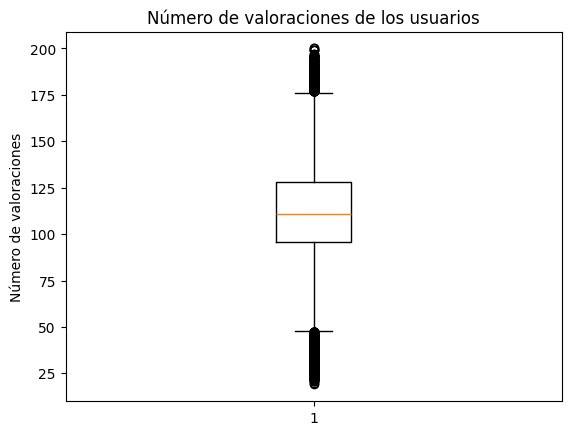

In [22]:
# Diagrama de caja de las valoraciones de los usuarios
plt.boxplot(users_n_ratings['rating'])
plt.ylabel('Número de valoraciones')
plt.title('Número de valoraciones de los usuarios')
plt.show()

Como vemos, la primera observación dentro del rango intercuartílico es próxima a las 50 valoraciones; mientras que la última observación dentro del rango se corresponde con unas 175 valoraciones. Fuera de esos extremos se encuentran los datos atípicos, que quizá interese ignorar; si bien en caso de hacerlo, desecharíamos en todo caso aquellos usuarios con menos de 50 valoraciones, por no contar con un perfil marcadamente construido.

In [23]:
# user_ratings dataset with users with more than 100 ratings
user_ratings_100 = user_ratings[user_ratings['user_id'].isin(users_n_ratings[users_n_ratings['rating'] >= 100].index)]
len(user_ratings_100)

4615637

In [24]:
user_ratings_100.describe()

,user_id,book_id,rating
count,4.615637e+06,4.615637e+06,4.615637e+06
mean,2.531580e+04,1.900216e+03,3.901508e+00
std,1.536385e+04,2.386865e+03,9.896829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.186400e+04,1.900000e+02,3.000000e+00
50%,2.458000e+04,8.200000e+02,4.000000e+00
75%,3.839800e+04,2.738000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


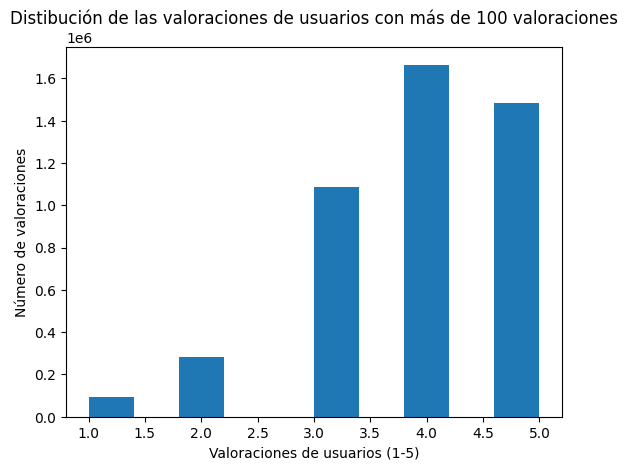

In [25]:
plt.hist(user_ratings_100['rating'])
plt.xlabel('Valoraciones de usuarios (1-5)')
plt.ylabel('Número de valoraciones')
plt.title('Distibución de las valoraciones de usuarios con más de 100 valoraciones')
plt.show()

Como vemos, se conserva la distribución de las valoraciones del dataset original en este dataset recortado para incluir sólo las valoraciones de aquellos usuarios que han leído y valorado 100 o más libros.

In [26]:
user_ratings_100.groupby('user_id').count().describe()

,book_id,rating
count,37084.000000,37084.000000
mean,124.464378,124.464378
std,18.821414,18.821414
min,100.000000,100.000000
25%,110.000000,110.000000
50%,120.000000,120.000000
75%,135.000000,135.000000
max,200.000000,200.000000


Hemos pasado de 53424 usuarios a 36199 usuarios, lo que, como preveíamos, supone alrededor del 70% del dataset original.

### <a id='toc1_1_4_'></a>[Otros datasets](#toc0_)

El conglomerado de datasets también incluye otros como `book_tags.csv`, `tags.csv` o `to_read.csv`. Estos no nos interesarán, salvo quizá el último en combinación con `ratings.csv` (ayuda a comprender mejor el perfil de cada usuario, pues incluye una lista de libros que le interesaría leer en el futuro). 

No obstante, los datasets sobre *tags* pueden ofrecer ideas en cuanto a la extracción de información identificativa de los libros y su contenido, lo cual resulta similar a lo que se intentará realizar a partir de NLP con las sinopsis de los mismos.